In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [253]:
import os
import tqdm

from itertools import combinations, permutations

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_config

from sklearn.model_selection._split import _BaseKFold

## Constants

In [5]:
config = load_config()

In [22]:
PREPROCESSED_DIR = config['preprocessed_data']
FINAL_DIR = config['final_data']

BRAZIL_TRAIN = os.path.join(PREPROCESSED_DIR, 'preprocessed_brazil_train.csv')
BRAZIL_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_brazil_eval.csv')
FRANCE_TRAIN = os.path.join(PREPROCESSED_DIR, 'preprocessed_france_train.csv')
FRANCE_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_france_eval.csv')
MINI_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_mini_brazil_eval.csv')

In [74]:
datasets = {
    'tr_brazil' : BRAZIL_TRAIN,
    'tr_france' : FRANCE_TRAIN,
    'ev_brazil' : BRAZIL_EVAL,
    'ev_france' : FRANCE_EVAL,
    'ev_mini' : MINI_EVAL
}

## Load and view data

In [283]:
df_ = {}
for key, directory in datasets.items():
    df_[key] = pd.read_csv(directory)

/tmp/ipykernel_268014/3510531832.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_[key] = pd.read_csv(directory)
/tmp/ipykernel_268014/3510531832.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_[key] = pd.read_csv(directory)


In [284]:
# df_train_brazil = pd.read_csv(BRAZIL_TRAIN)
# df_train_france = pd.read_csv(FRANCE_TRAIN)

In [285]:
# df_eval_brazil = pd.read_csv(BRAZIL_EVAL)
# df_eval_france = pd.read_csv(FRANCE_EVAL)
# df_eval_mini = pd.read_csv(MINI_EVAL)

### Sanity Checks

In [286]:
# check unique stations in train
df_['tr_brazil'].station_code.nunique(), df_['tr_france'].station_code.nunique()

(9, 30)

In [287]:
# check unique stations in eval
df_['ev_brazil'].station_code.nunique(), df_['ev_france'].station_code.nunique(), df_['ev_mini'].station_code.nunique()

(13, 39, 2)

In [288]:
# check data shape
df_['tr_brazil'].shape, df_['tr_france'].shape

((6579, 175), (21930, 176))

france has one more column than brazil. find the different column

In [289]:
diff_col = set(df_['tr_brazil'].columns).symmetric_difference(set(df_['tr_france'].columns))
diff_col

{'next_downstream_station'}

### Clean and prep
- Filter out non-uniform variables
- drop columns

In [290]:
# remove 'next_downstream_station' from france
for key, directory in datasets.items():
    df_[key] = df_[key].drop(columns = diff_col, errors = 'ignore')
df_['tr_france'].shape, df_['ev_france'].shape

((21930, 175), (5070, 175))

In [291]:
COLS_TO_DROP = ['station_name', 'id_region', 'id_sector', 'id_sub_sector', 'id_zone','geometry', 'eval_only']

In [292]:
for key in df_.keys():
    df_[key] = df_[key].drop(columns = COLS_TO_DROP, errors = 'ignore')
    print(key, df_[key].shape)

tr_brazil (6579, 168)
tr_france (21930, 168)
ev_brazil (1690, 168)
ev_france (5070, 168)
ev_mini (190, 168)


#### Feature engineering strategy
- create temporal features
- categorical features
- PCA soil features to reduce dimensionality
- location encoding
- Train test split before lag/rolling features
- lag features for discharge
- lag features for meteo
- rolling features for meteo

In [293]:
LOCATION = ['longitude', 'latitude']
CATEGORICAL = ['station_code', 'river', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone']
NUM_STATION = ['altitude', 'catchment']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
DISCHARGE = 'discharge'
DATE = 'ObsDate'

### Temporal Features

In [294]:
for key in df_.keys():
    # extract df
    temp = df_[key]
    # convert to datetime and temporal features
    temp['ObsDate'] = pd.to_datetime(temp.ObsDate)
    temp['year'] = temp.ObsDate.dt.year
    temp['month'] = temp.ObsDate.dt.month
    temp['week'] = temp.ObsDate.dt.isocalendar().week

    # compute new features 
    # season
    temp['season'] = temp.month.apply(lambda x: (x-1) // 3 + 1) # 1, 2, 3, 4

    # sinusoidial patterns
    sigmas = [4, 8]
    for sigma in sigmas:
        temp[f'gaussian_{sigma}'] =  np.exp(-(((temp.week + 23) % 52 - 52/2) ** 2) / (2 * sigma ** 2))

    # convert to categorical
    temp['year'] = temp.year.astype('category')
    temp['month'] = temp.month.astype('category')
    temp['week'] = temp.week.astype('category')
    temp['season'] = temp.season.astype('category')

### Categorical features

In [295]:
hydro_scale_combinations = list(combinations(['region', 'sector', 'sub_sector', 'zone'], 2))
for key in df_.keys():
    temp = df_[key]
    
    # create hydro feature interaction
    for comb in hydro_scale_combinations:
        col = comb[0] + '_' + comb[1]
        temp[col] = temp.apply(lambda x: str(x[f'hydro_{comb[0]}']) + '_' + str(x[f'hydro_{comb[1]}']), axis = 1).astype('category')
        
    # convert other categorical vars to category
    for col in CATEGORICAL:
        temp[col] = temp[col].astype('category')

### Location Encoding

In [310]:
def encode_location(lat, lon):
    lat_rad = np.radians(lat)  # Convert to radians
    lon_rad = np.radians(lon)
    
    lat_sin = np.sin(lat_rad)
    lat_cos = np.cos(lat_rad)
    lon_sin = np.sin(lon_rad)
    lon_cos = np.cos(lon_rad)
    
    location_encoding = pd.Series([lat_sin, lat_cos, lon_sin, lon_cos])
    return location_encoding

In [311]:
for key in df_.keys():
    temp = df_[key]
    temp[['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']] = temp.apply(lambda x: encode_location(x.latitude, x.longitude), axis = 1)

### combine datasets

In [324]:
# assign country
for key in df_.keys():
    location = key.split('_')[-1]
    dataset = key.split('_')[0]
    if location == 'mini':
        location = 'brazil'
        dataset = 'mini'
    df_[key]['location'] = location
    if dataset == 'tr':
        continue
    df_[key]['dataset'] = dataset

In [327]:
df_train = pd.concat([df_['tr_brazil'], df_['tr_france']], ignore_index = True)
df_eval = pd.concat([df_['ev_brazil'], df_['ev_france'], df_['ev_mini']], ignore_index = True)

,station_code,ObsDate,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,...,gaussian_4,gaussian_8,region_sector,region_sub_sector,region_zone,sector_sub_sector,sector_zone,sub_sector_zone,location,dataset
0,56960005,2004-01-04,0.000706,0.000763,0.000743,293.36250,294.22080,294.62347,0.496604,0.495490,...,0.882497,0.969233,1351936_1351808,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,brazil,ev
1,56960005,2004-01-11,0.000363,0.000414,0.000402,294.29270,295.05222,295.54907,0.492507,0.492499,...,0.969233,0.992218,1351936_1351808,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,brazil,ev
2,56960005,2004-01-18,0.000393,0.000477,0.000528,294.97452,295.84048,296.37192,0.494070,0.494040,...,1.0,1.0,1351936_1351808,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,brazil,ev
3,56960005,2004-01-25,0.000070,0.000071,0.000072,294.39620,295.33337,295.78850,0.441748,0.443167,...,0.969233,0.992218,1351936_1351808,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,brazil,ev
4,56960005,2004-02-01,0.000082,0.000087,0.000094,295.51962,296.24866,296.78857,0.413392,0.415214,...,0.882497,0.969233,1351936_1351808,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,brazil,ev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6945,56992400,2015-02-22,0.000149,0.000193,0.000205,300.49072,299.93530,299.41788,0.253447,0.292021,...,0.457833,0.822578,1351936_1351807,1351936_1351034,1351936_1345589,1351807_1351034,1351807_1345589,1351034_1345589,brazil,mini
6946,56992400,2015-03-01,0.000913,0.001199,0.001475,300.25015,299.69640,299.13280,0.269462,0.313582,...,0.324652,0.75484,1351936_1351807,1351936_1351034,1351936_1345589,1351807_1351034,1351807_1345589,1351034_1345589,brazil,mini
6947,56992400,2015-03-08,0.000532,0.000650,0.000894,299.62433,299.05612,298.45883,0.322717,0.368906,...,0.216265,0.681941,1351936_1351807,1351936_1351034,1351936_1345589,1351807_1351034,1351807_1345589,1351034_1345589,brazil,mini
6948,56992400,2015-03-15,0.000017,0.000031,0.000042,300.58660,300.06256,299.47528,0.247126,0.291954,...,0.135335,0.606531,1351936_1351807,1351936_1351034,1351936_1345589,1351807_1351034,1351807_1345589,1351034_1345589,brazil,mini


### Train Test Split
- Before generating rolling features, we split the data to prevent data leakage.
- Based on previous analysis, the dataset exhibits annual seasonality but no significant long-term trend.
- Therefore, it is acceptable to use chronological or block-wise splits without always reserving the most recent data for validation.
- This approach is appropriate for seasonally-repeating time series, where the assumption of trend-driven data drift does not hold.
- In such cases, the model's ability to generalize across seasonal cycles is more important than strict recency.

In [298]:
class ContiguousGroupKFold(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, random_state = None, shuffle = False)

    def split(self, X, y = None, groups = None):
        if groups is None:
            raise ValueError("The 'groups' parameter is required for ContiguousGroupKFold.")

        # get unique groups
        unique_groups = sorted(np.unique(groups))
        n_groups = len(unique_groups)

        # ensure n_splits is less than or equal to num_groups
        if self.n_splits > n_groups:
            raise ValueError(f"Cannot have number of splits = {self.n_splits} greater than the number of groups = {n_groups}.")

        fold_sizes = np.full(self.n_splits, n_groups // self.n_splits, dtype=int)
        fold_sizes[:n_groups % self.n_splits] += 1

        group_starts = np.cumsum(np.insert(fold_sizes, 0, 0))[:-1]

        for i in range(self.n_splits):
            test_start = group_starts[i]
            test_end = test_start + fold_sizes[i]
            test_groups = unique_groups[test_start:test_end]

            test_mask = np.isin(groups, test_groups)
            train_mask = ~test_mask

            yield np.where(train_mask)[0], np.where(test_mask)[0]


In [300]:
ckf = ContiguousGroupKFold(5)

In [301]:
for train_idx, val_idx in ckf.split(samp, groups = samp.year):
    print(samp.iloc[train_idx].year.unique())
    print(samp.iloc[val_idx].year.unique())

[1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004]
[1990 1991 1992]
[1990 1991 1992 1996 1997 1998 1999 2000 2001 2002 2003 2004]
[1993 1994 1995]
[1990 1991 1992 1993 1994 1995 1999 2000 2001 2002 2003 2004]
[1996 1997 1998]
[1990 1991 1992 1993 1994 1995 1996 1997 1998 2002 2003 2004]
[1999 2000 2001]
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001]
[2002 2003 2004]


In [277]:
fold_sizes = np.full(5, 15 // 5, dtype=int)
fold_sizes[:15 % 5] += 1
group_starts = np.cumsum(np.insert(fold_sizes, 0, 0))[:-1]
fold_sizes, group_starts

(array([3, 3, 3, 3, 3]), array([ 0,  3,  6,  9, 12]))

In [274]:
df_['tr_france'].year.nunique()

15

In [267]:
df_['tr_france'].select_dtypes('category')

,station_code,river,hydro_region,hydro_sector,hydro_sub_sector,hydro_zone,year,month,week,season,region_sector,region_sub_sector,region_zone,sector_sub_sector,sector_zone,sub_sector_zone
0,6125320,MUZE,O,O3,O34,O345,1990,1,1,1,O_O3,O_O34,O_O345,O3_O34,O3_O345,O34_O345
1,6125320,MUZE,O,O3,O34,O345,1990,1,2,1,O_O3,O_O34,O_O345,O3_O34,O3_O345,O34_O345
2,6125320,MUZE,O,O3,O34,O345,1990,1,3,1,O_O3,O_O34,O_O345,O3_O34,O3_O345,O34_O345
3,6125320,MUZE,O,O3,O34,O345,1990,1,4,1,O_O3,O_O34,O_O345,O3_O34,O3_O345,O34_O345
4,6125320,MUZE,O,O3,O34,O345,1990,2,5,1,O_O3,O_O34,O_O345,O3_O34,O3_O345,O34_O345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21925,6139795,LISON,U,U2,U26,U261,2003,12,49,4,U_U2,U_U26,U_U261,U2_U26,U2_U261,U26_U261
21926,6139795,LISON,U,U2,U26,U261,2003,12,50,4,U_U2,U_U26,U_U261,U2_U26,U2_U261,U26_U261
21927,6139795,LISON,U,U2,U26,U261,2003,12,51,4,U_U2,U_U26,U_U261,U2_U26,U2_U261,U26_U261
21928,6139795,LISON,U,U2,U26,U261,2003,12,52,4,U_U2,U_U26,U_U261,U2_U26,U2_U261,U26_U261


#### Lag and rolling Features

In [218]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf

In [219]:
df_['tr_france'].station_code.unique()

array([6125320, 6139640, 6139790, 6139261, 6125440, 6119110, 6119040,
       6139940, 6939050, 6139770, 6119020, 6139920, 6139900, 6119120,
       6124510, 6125220, 6139361, 6139910, 6139520, 6139360, 6124501,
       6119200, 6139550, 6139825, 6139681, 6139061, 6125630, 6139921,
       6139560, 6139795])

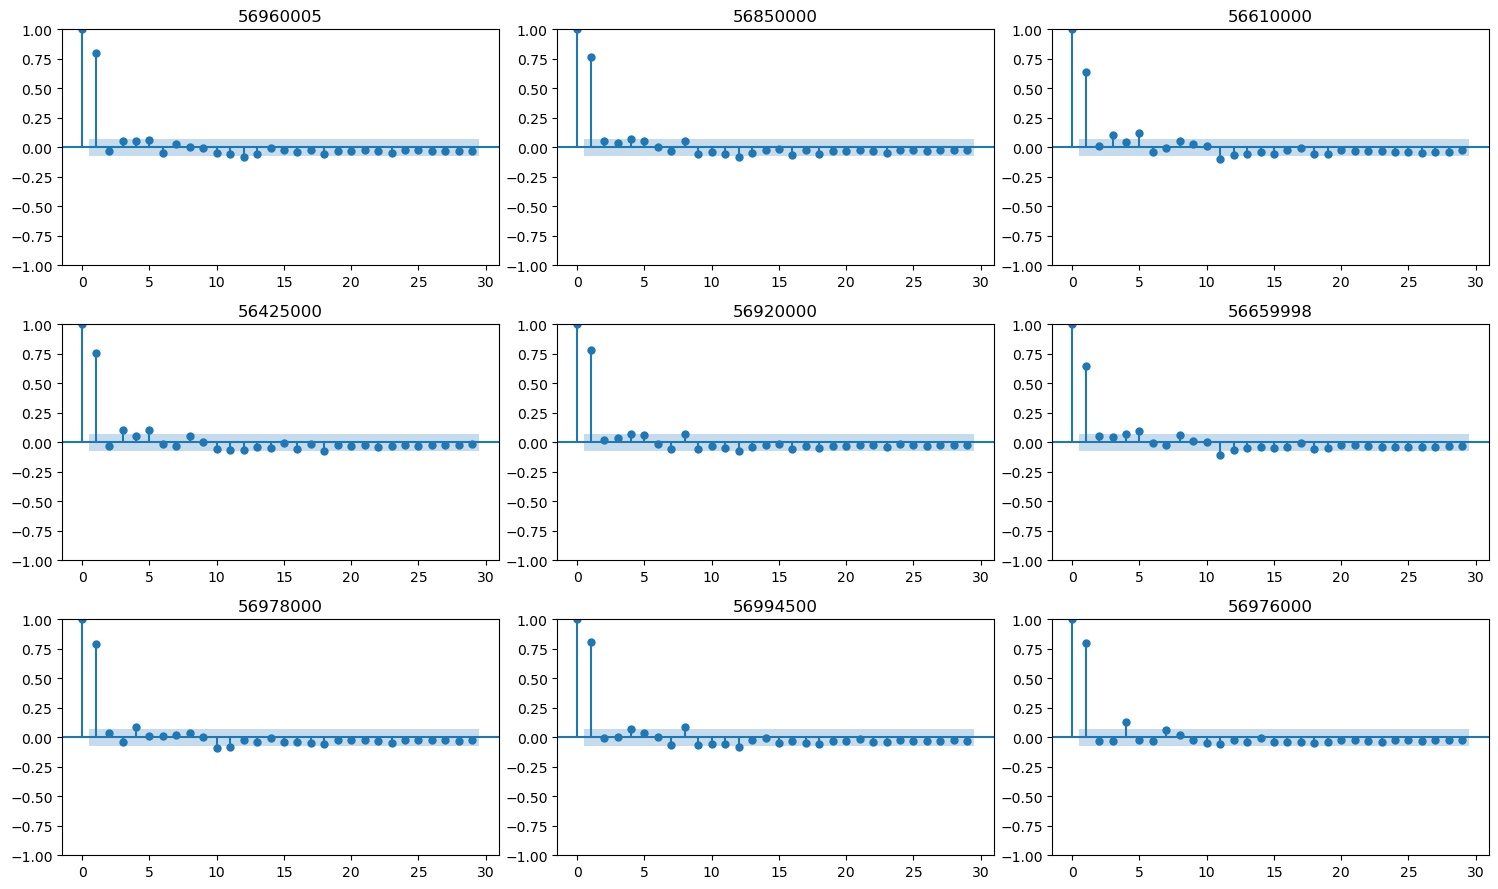

In [220]:
samp = sample = df_['tr_brazil']
fig, ax = plt.subplots(3, 3, figsize = (15, 9))
ax = ax.flatten()
for i, sc in enumerate(samp.station_code.unique()):
    temp = samp[samp.station_code == sc]
    t_pacf = pacf(temp.discharge)
    plot_pacf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

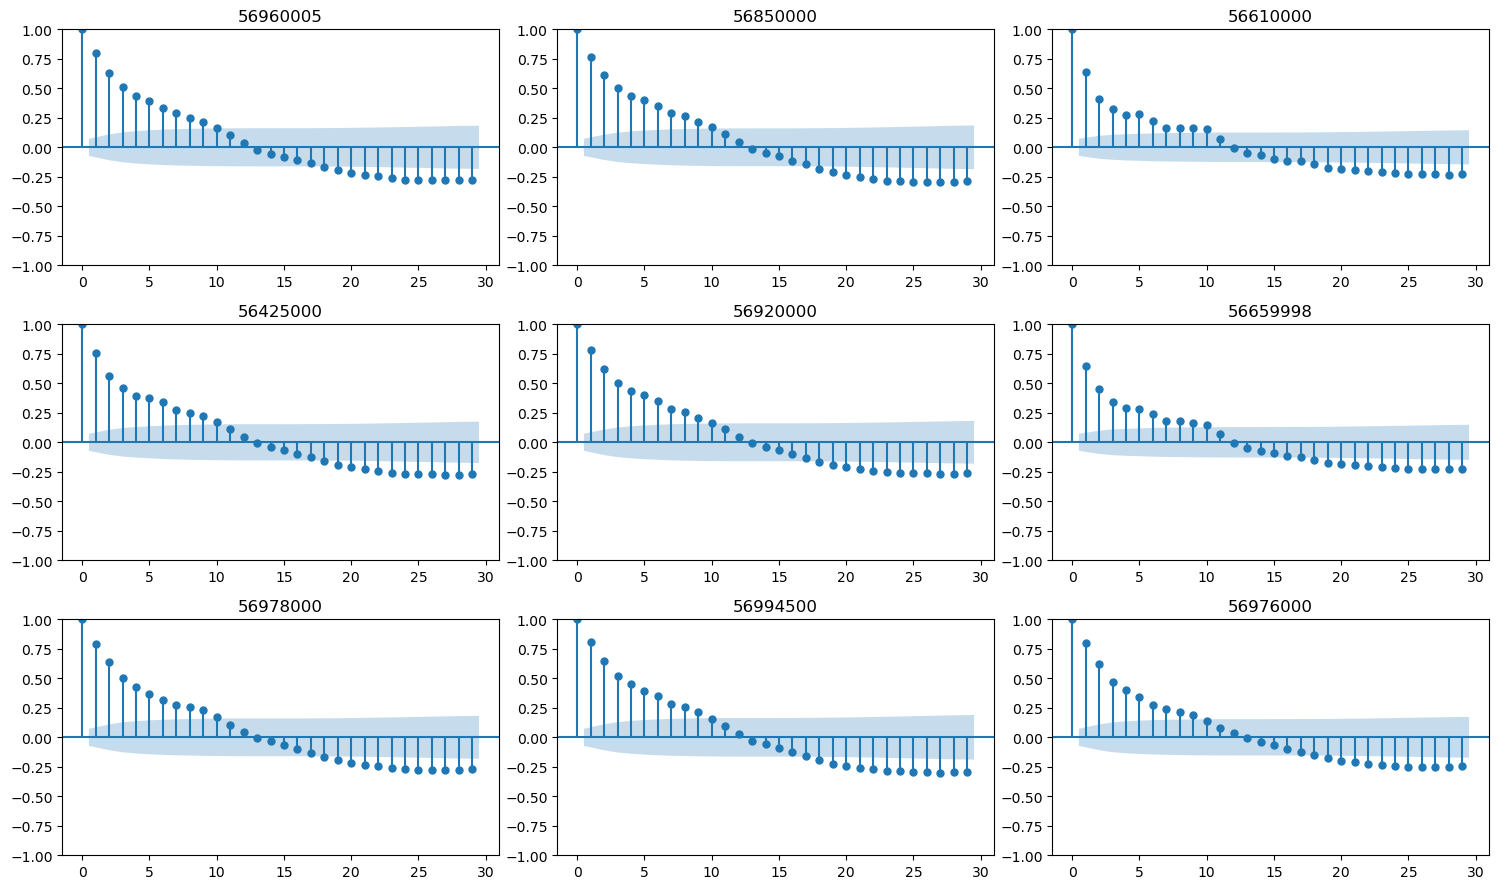

In [221]:
samp = sample = df_['tr_brazil']
fig, ax = plt.subplots(3, 3, figsize = (15, 9))
ax = ax.flatten()
for i, sc in enumerate(samp.station_code.unique()):
    temp = samp[samp.station_code == sc]
    plot_acf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

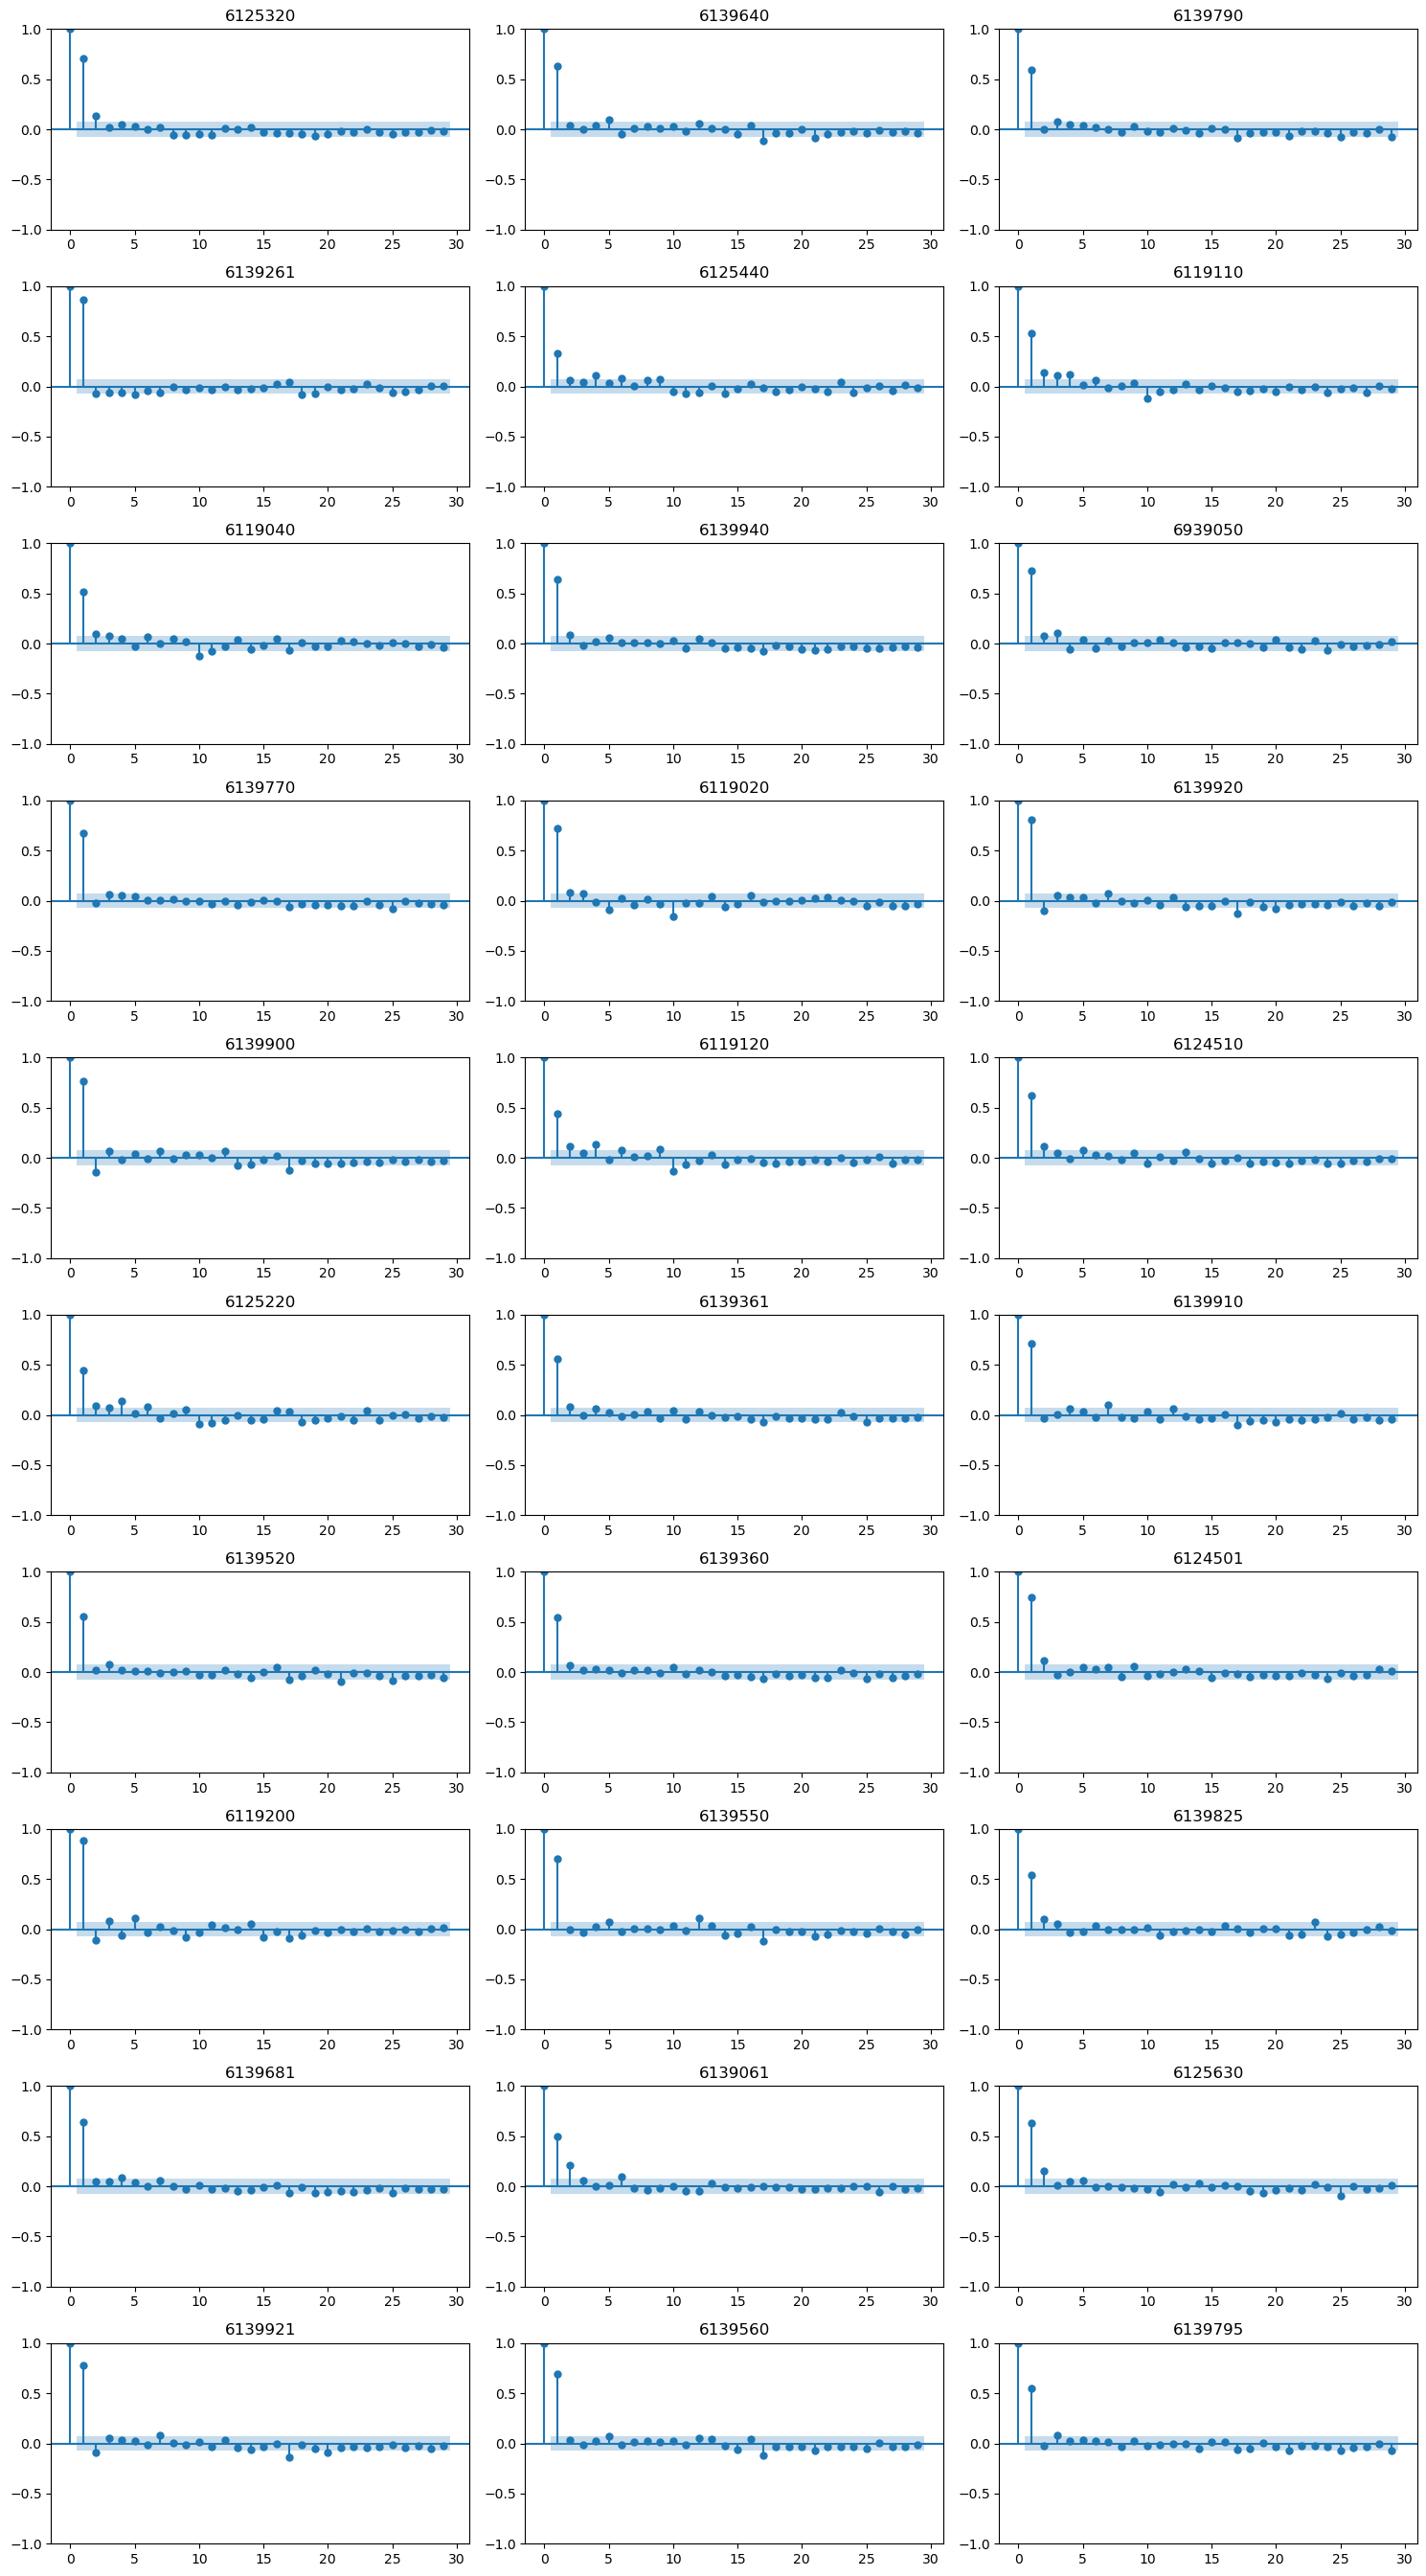

In [222]:
samp = sample = df_['tr_france']
fig, ax = plt.subplots(10, 3, figsize = (15, 27))
ax = ax.flatten()
for i, sc in enumerate(samp.station_code.unique()):
    temp = samp[samp.station_code == sc]
    t_pacf = pacf(temp.discharge)
    plot_pacf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

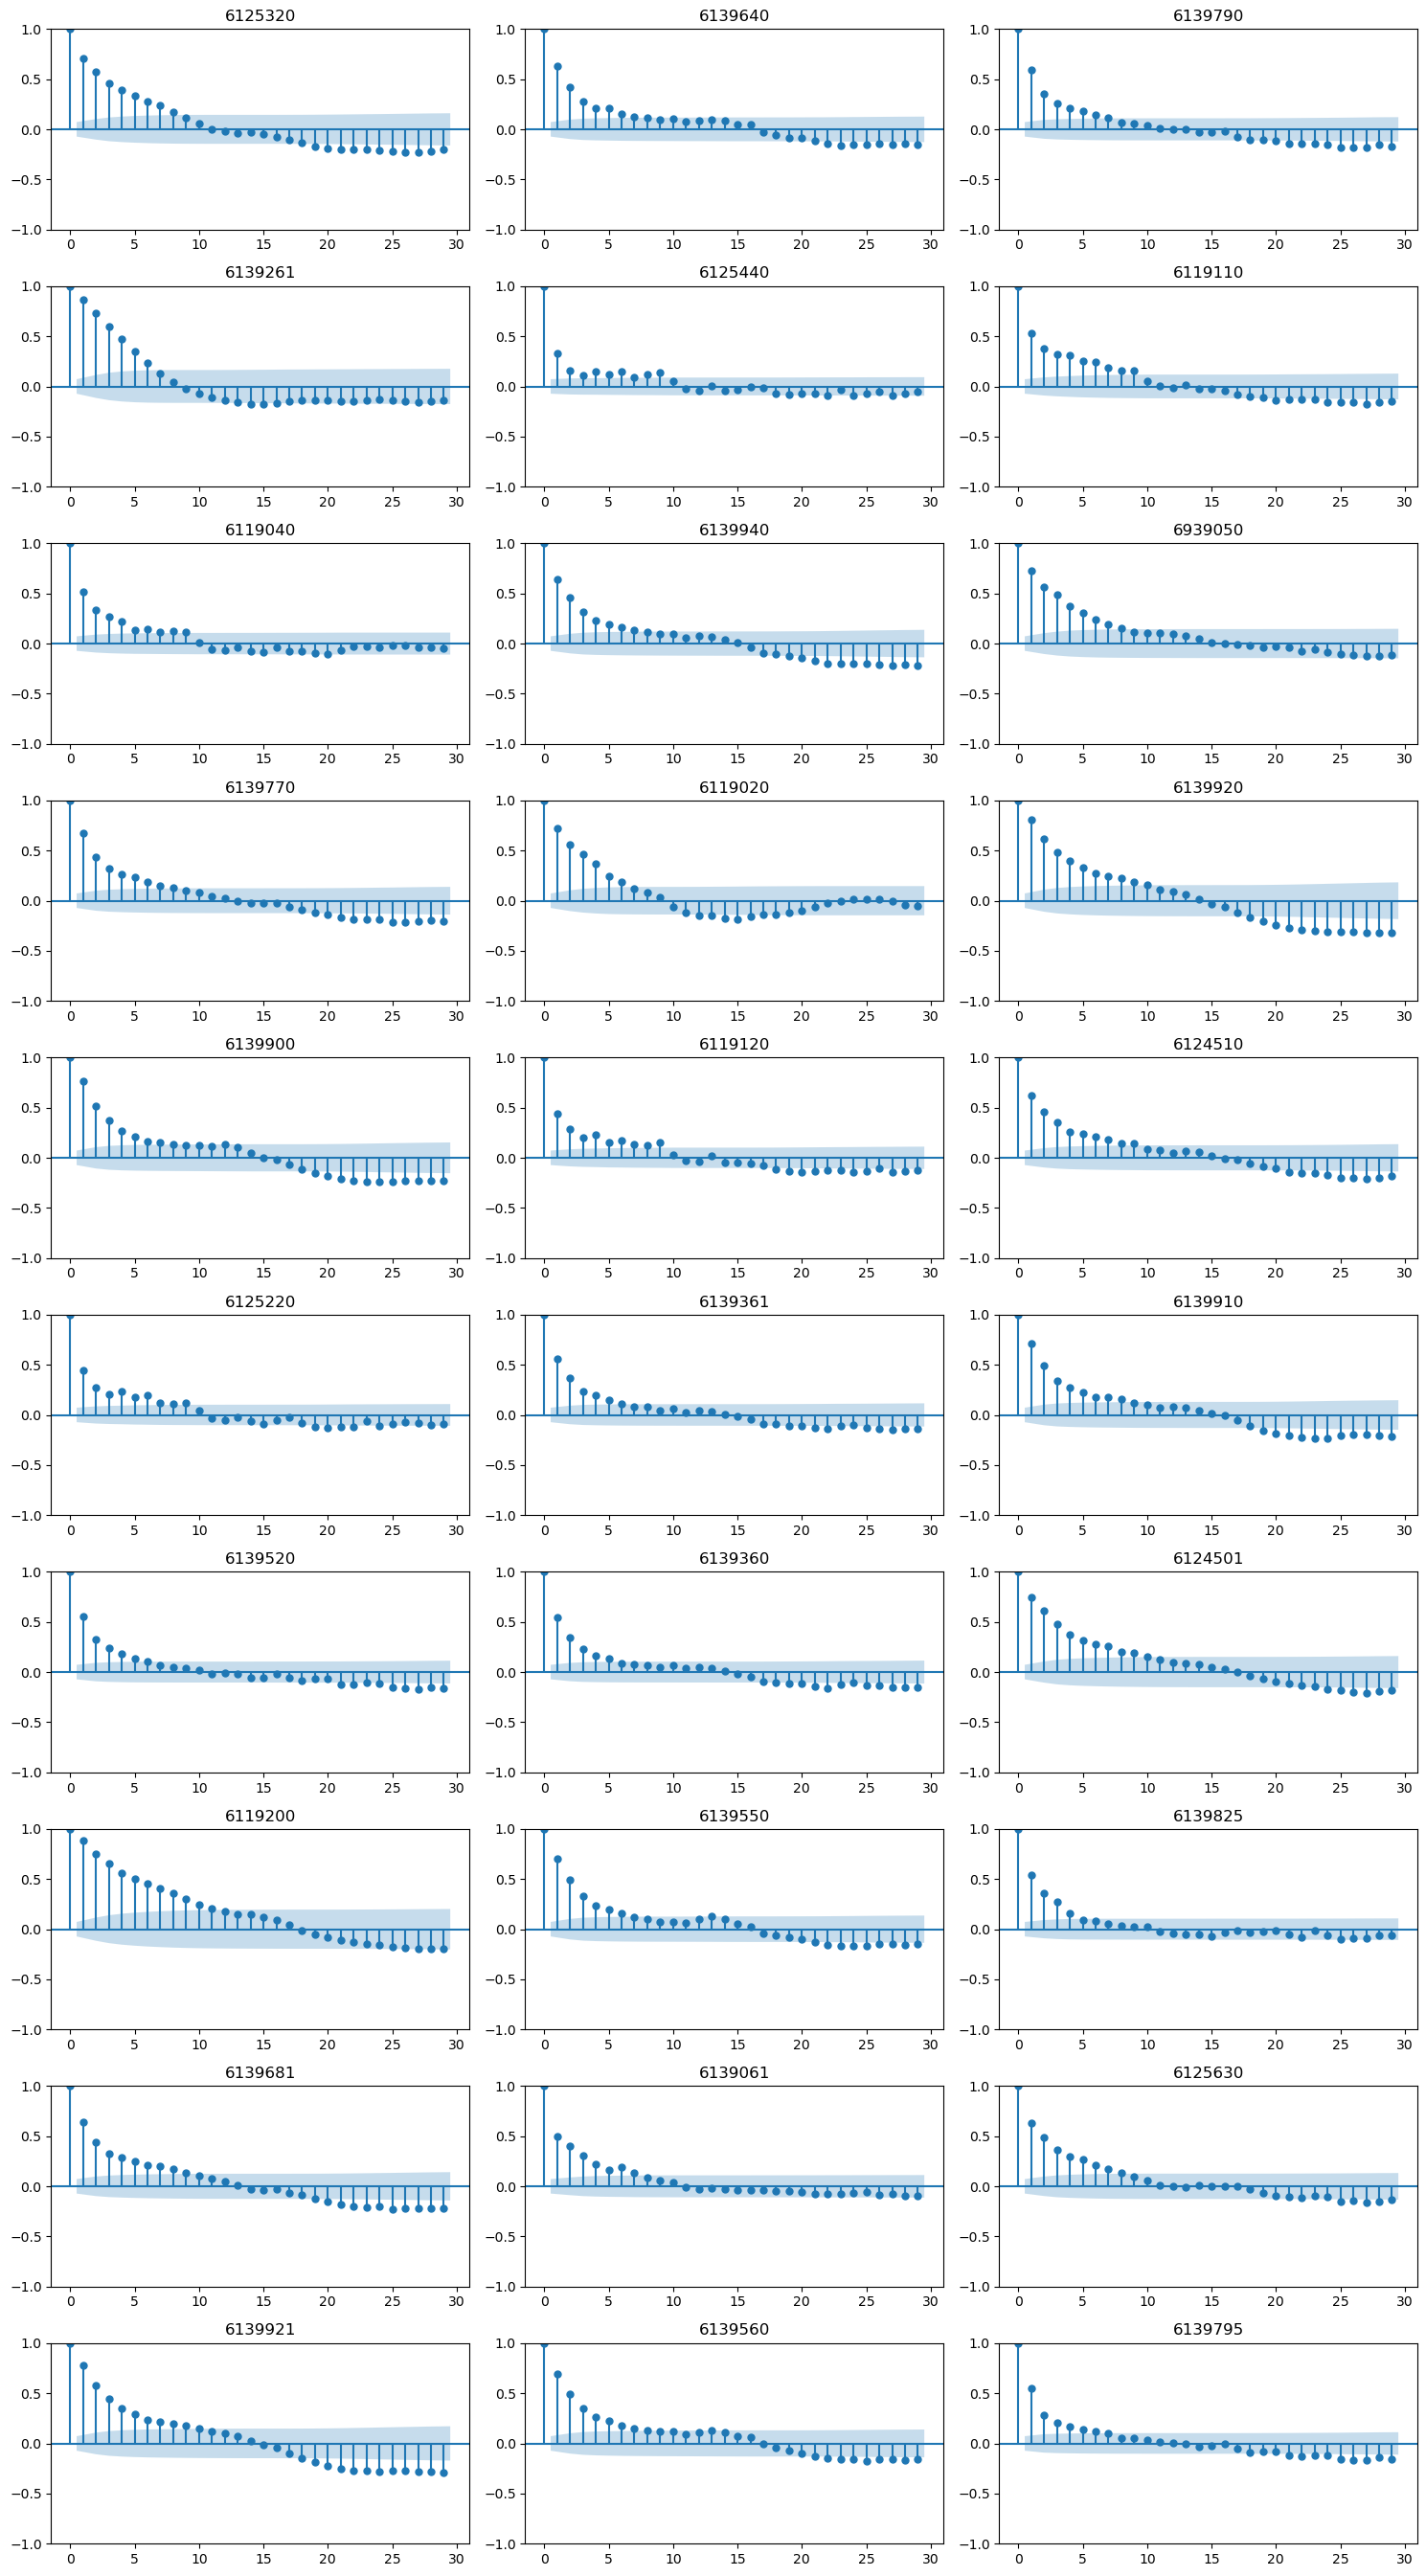

In [223]:
samp = sample = df_['tr_france']
fig, ax = plt.subplots(10, 3, figsize = (15, 27))
ax = ax.flatten()
for i, sc in enumerate(samp.station_code.unique()):
    temp = samp[samp.station_code == sc]
    # t_pacf = pacf(temp.discharge)
    plot_acf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

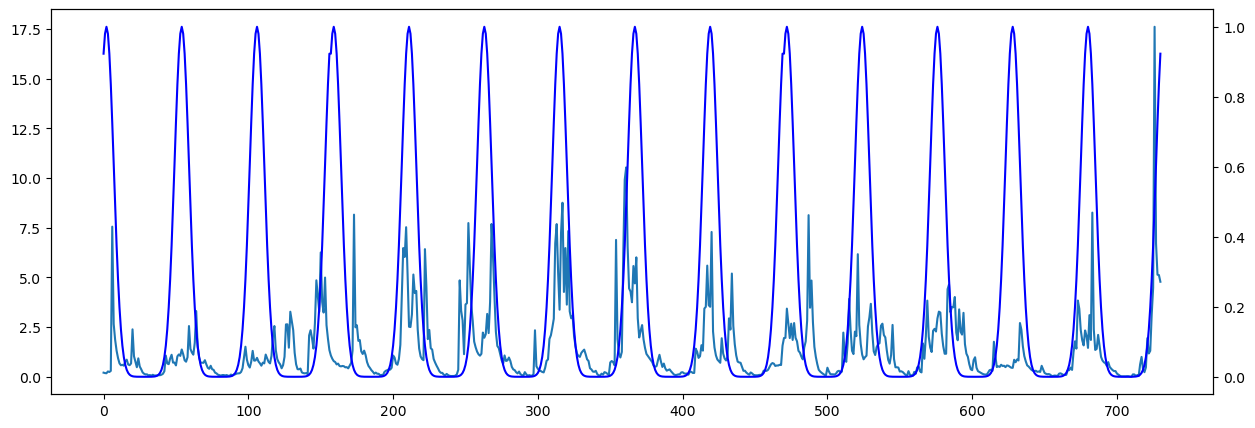

In [224]:
sc = samp.station_code.unique()[0]
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(samp[samp.station_code == sc].discharge)
ax2 = ax.twinx()
# ax2.plot(samp[samp.station_code == sc].tp, color = 'r')
ax2.plot(samp[samp.station_code == sc].gaussian_5, color = 'b')

In [225]:
identified_lag = 1 c